# pyfabric example 03.1: trabecular bone fabric tensor; multi-resolution; extract trabecular bone cores for further analysis
Fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 04.05.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
1. Load and inspect QCT and HR-pQCT datasets of the proximal femur using simpleITK
2. detect alignment cement markers on QCT image
3. resample QCT dataset to isotropic voxel size
4. apply median filter to QCT dataset
5. compute transformation matrices for QCT to HR-pQCT image registration
6. apply 3D affine registration transformation to register QCT data to HR-pQCT
7. load (compute ?) mask of whole bone and of trabecular bone
8. compute trabecular core mesh; find centroids for trabecular cores extraction
9. for each centroid
    - crop cube portion from QCT dataset and save as .MHA
    - crop cube portion from HR-pQCT and save as separate stack of TIFFs
10. save results:
    - transformation matrix QCT 2 HR-pQCT
    - trabecular core mesh
    - list of trabecular centroid coordinates

---
## Configuration and imports

In [1]:
import os
import sys

In [2]:
# gianthk@thkdebian
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')
sys.path.append('/home/gianthk/PycharmProjects/BEATS/recon_utils')

In [2]:
# beatsbs@BL-BEATS-WS01
sys.path.append('/home/beatsbs/PycharmProjects/user/pyfabric')
sys.path.append('/home/beatsbs/PycharmProjects/recon_utils')

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import heapq
import pandas as pd
import SimpleITK as sitk

from imaging_utils import periosteummask
from resources.myshow import myshow, myshow3d
from recon_utils import plot_midplanes, plot_projections
import pyfabric
from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

## Functions definition

In [6]:
def plot_midplanes_sitk(img):
    plot_midplanes(sitk.GetArrayFromImage(img))

def plot_projections_sitk(img):
    plot_projections(sitk.GetArrayFromImage(img))

## Computational workflow
### Settings

In [8]:
# gianthk@thkdebian
work_dir = '/home/gianthk'
data_dir = '/media/gianthk/My Passport/Data/TacoSound'

In [7]:
# beatsbs@BL-BEATS-WS01
work_dir = '/run/media/beatsbs/My Passport/Data/TacoSound'
data_dir = '/run/media/beatsbs/My Passport/Data/TacoSound'

In [8]:
output_dir = data_dir 

specimen = '1955_L_S'
master_filename = 'tacosound_master_all.csv'
master_filename = os.path.join(data_dir, master_filename)

input_file_HR = os.path.join(data_dir, 'XtremeCT-II/1955_L/C0001577.ISQ')
output_file_HR = os.path.join(data_dir, 'XtremeCT-II/1955_L/C0001577.mhd')
input_file_HR_res = os.path.join(data_dir, 'XtremeCT-II/00_resampled_data/1955_L/C0001577.mhd')

# input_dir_QCT_DCM = '/home/gianthk/Data/TacoSound/QCTFEMUR_1955L_new/QCTFEMUR_1955L/Q_CT_DIAGBILANZ_HR_0003'
input_dir_QCT_DCM = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/Q_CT_DIAGBILANZ_HR_0003')
# input_file_QCT = work_dir + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

### Read and inspect HR-pQCT input data
We use the following tools:
- [scanco_read_files.py from ORMIR/pymsk package](https://github.com/ORMIRcommunity/pymsk/blob/master/pymsk/scanco_read_files.py)
- [isq_io_viz.ipynb from the ORMIR notebooks](https://github.com/JCMSK/nb_gallery/blob/master/isq_io_viz.ipynb)

#### Extracting information from isq image header
- To read the .isq file headers, we use the function `read_isq_header()` from `pymsk`  
- For each image, we will get two lists: 
    - `keys`, containing all the information labels (e.g. *pixel_size_um*, etc.)
    - `values`, containing all the actual values (e.g. *82*, etc.)

In [16]:
help(scanco_read_files.read_isq_header)

Help on function read_isq_header in module pymsk.scanco_read_files:

read_isq_header(isq_file_name)
    This function reads an .isq file header and returns its content as two lists of strings: "keys" and "values"
    The list "keys" contains the data labels (e.g. pixel_size_um).
    The list "value" contains the actual values (e.g. 82)
    The keys are from the Scanco documentation at http://www.scanco.ch/en/support/customer-login/faq-customers.html, under "general" -> "ISQ Header format"
    
    Input:
        - isq_file_name: name of the isq file (type: str)
    Outputs:
        - keys: contains the data labels (type: list of strings)
        - values: contains the actual values (type: list of strings)



In [10]:
# get keys and values from the header of the current image
keys, values = scanco_read_files.read_isq_header(input_file_HR) 

Create metadata table containing:  
- Image metadata from *.isq* header
- Subject metadata and other metadata collected by an operator in a tabular file (e.g. *.csv*)  

In [15]:
# create dataframe (=table)
isq_headers = pd.DataFrame([values], columns = keys)

# adding column with file names in position 0
isq_headers.insert(0, "file_name", input_file_HR)

# delete column "fill" because it just contains zeros
isq_headers = isq_headers.drop(columns = ["fill"])

# show dataframe
isq_headers

file_name             check  \
0  /run/media/beatsbs/My Passport/Data/TacoSound/...  CTDATA-HEADER_V1   

   data_type  nr_of_bytes  nr_of_blocks  pat_no  scanner_id        date  \
0          3            0     491111431      15        3403  2015_09_27   

   n_voxels_x  n_voxels_y  ...  scanner_type  exposure_time  meas_no  site  \
0        4608        4608  ...             9         200000       11     4   

   reference_line_um  recon_algo                                  pat_name  \
0              13575           3  TaCoSound_1955_L                           

   energy_V  intensity_uA  data_offset  
0     68000          1470            6  

[1 rows x 33 columns]

#### Reading a *.ISQ* image

In [10]:
# read the image with https://github.com/KitwareMedical/ITKIOScanco
import itk

data_3D = itk.imread(input_file_HR)

#### Write to disk as MetaImage

In [13]:
itk.imwrite(data_3D, output_file_HR)

#### Read a high resolution *.mhd* image

In [9]:
data_3D = sitk.ReadImage(output_file_HR, imageIO="MetaImageIO")

In [186]:
# print out the usual SimpleITK image characteristics
print (data_3D.GetSize())
print (data_3D.GetSpacing())
print (data_3D.GetOrigin())
print (data_3D.GetDirection())

(4608, 4608, 5921)
(0.030299913194444448, 0.030299913194444448, 0.03029994933288296)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


#### ! For the moment we use resampled data !

In [187]:
data_3D_res = sitk.ReadImage(input_file_HR_res, imageIO="MetaImageIO")

In [188]:
# print out the usual SimpleITK image characteristics
print (data_3D_res.GetSize())
print (data_3D_res.GetSpacing())
print (data_3D_res.GetOrigin())
print (data_3D_res.GetDirection())

(460, 460, 592)
(0.303, 0.303, 0.303)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [10]:
size_HRpQCT = data_3D.GetSize()
print("Image size:", size_HRpQCT[0], size_HRpQCT[1], size_HRpQCT[2])
vs_HRpQCT = data_3D.GetSpacing() # it's a tuple
print("Image spacing:", vs_HRpQCT[0], vs_HRpQCT[1], vs_HRpQCT[2])
dimension = data_3D.GetDimension()
print("Dimension: ", dimension)

Image size: 4608 4608 5921
Image spacing: 0.030299913194444448 0.030299913194444448 0.03029994933288296
Dimension:  3


Inspect dataset

In [ ]:
plot_midplanes_sitk(data_3D)

#### Read coordinates of cement markers
Read study master table

In [245]:
master = pd.read_csv(master_filename, sep=',') # names=column_names, dtype=float

In [246]:
master.head()

$specimen  $donor       $site $config  $mechtest $sex  $age  $side  \
0  1955_L_S    1955  femur_prox  STANCE          1    m    88   LEFT   
1  1955_R_F    1955  femur_prox    FALL          1    m    88  RIGHT   
2  1956_L_S    1956  femur_prox  STANCE          0    m    82   LEFT   
3  1956_R_S    1956  femur_prox  STANCE          0    m    82  RIGHT   
4  1958_L_F    1958  femur_prox    FALL          1    w    80   LEFT   

   $h_sample  $femurh  ... $aBMDinter    $Aneck  $BMCneck $aBMDneck   $Awards  \
0    170.570       51  ...   0.805222  7.277173  3.807238  0.523175  1.170454   
1    166.132       51  ...   0.804763  8.223714  4.365356  0.530825  1.170454   
2    153.514       43  ...   0.609684  6.127074  2.165871  0.353492  1.109387   
3    157.494       43  ...   0.634896  6.004940  2.391120  0.398192  1.027964   
4    159.090       45  ...   0.733025  5.200888  2.273541  0.437145  1.262055   

   $BMCwards  $aBMDwards  $aBMDtot    $BMCtot      $Atot  
0   0.325666    0.278239  0.739938  40.200399  54.329436  
1   0.311581    0.266206  0.733125  42.344845  57.759376  
2   0.143702    0.129533  0.491730  20.849834  42.400980  
3   0.186689    0.181610  0.528859  23.608342  44.640110  
4   0.548343    0.434484  0.605319  25.986485  42.930229  

[5 rows x 115 columns]

In [247]:
specimen_master = master.loc[master['$specimen'] == specimen]

In [248]:
markers_coordinates_HR = np.array([[specimen_master['$M1x'][0], specimen_master['$M1y'][0], specimen_master['$M1z'][0]],
                                  [specimen_master['$M2x'][0], specimen_master['$M2y'][0], specimen_master['$M2z'][0]],
                                  [specimen_master['$M3x'][0], specimen_master['$M3y'][0], specimen_master['$M3z'][0]],
                                  [specimen_master['$M4x'][0], specimen_master['$M4y'][0], specimen_master['$M4z'][0]],
                                  [specimen_master['$M5x'][0], specimen_master['$M5y'][0], specimen_master['$M5z'][0]]])

In [249]:
print(markers_coordinates_HR)

[[101.714  92.103  14.022]
 [ 95.215  62.903  16.21 ]
 [ 41.419  74.894  16.994]
 [ 47.57  104.14   14.859]
 [100.051  84.267  14.167]]


Check correct position of markers coordinates

In [25]:
markers_slice = int(np.mean(markers_coordinates_HR[:,2])/vs_HRpQCT[2])
markers_pixel = (markers_coordinates_HR / vs_HRpQCT).astype('uint')

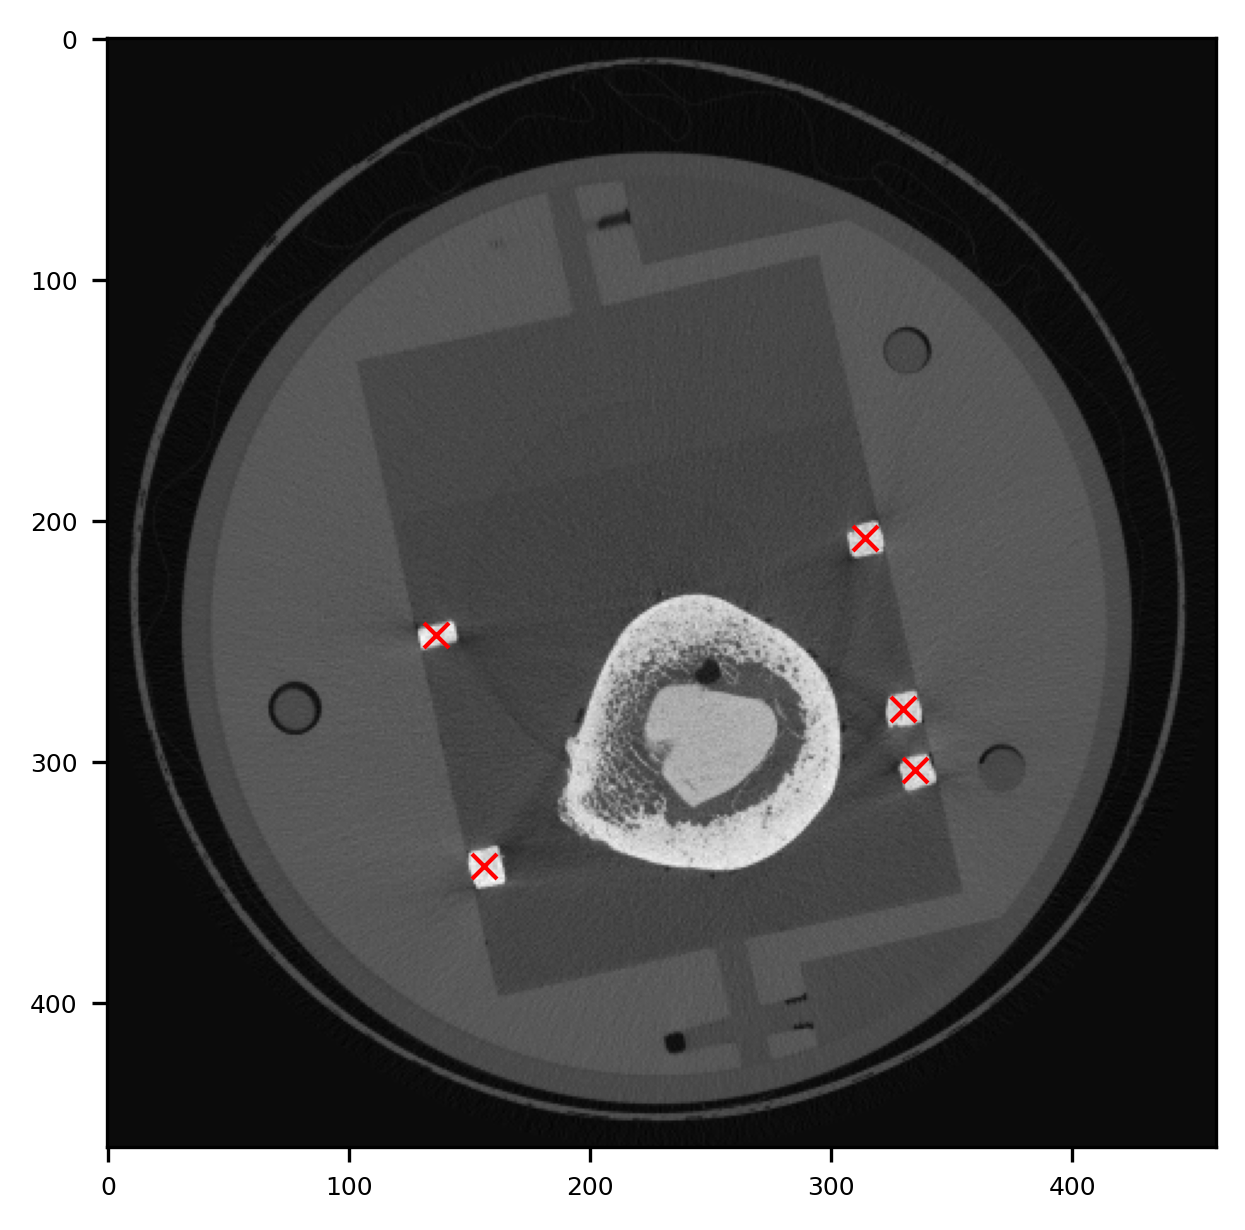

In [26]:
plt.imshow(sitk.GetArrayFromImage(data_3D)[markers_slice,:,:], cmap='grey')
plt.plot(markers_pixel[:,0], markers_pixel[:,1], 'xr')

### Read and inspect QCT input data

In [233]:
# read QCT dataset
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(input_dir_QCT_DCM)
reader.SetFileNames(dicom_names)

data_3D_QCT = reader.Execute()

ImageSeriesReader (0x47d8a70): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.594295



In [234]:
size_QCT = data_3D_QCT.GetSize()
print("Image size:", size_QCT[0], size_QCT[1], size_QCT[2])
vs_QCT = data_3D_QCT.GetSpacing() # it's a tuple
print("Image spacing:", vs_QCT[0], vs_QCT[1], vs_QCT[2])
dimension = data_3D_QCT.GetDimension()
print("Dimension: ", dimension)

Image size: 512 512 632
Image spacing: 0.29296875 0.29296875 0.30570522979397796
Dimension:  3


Inspect dataset

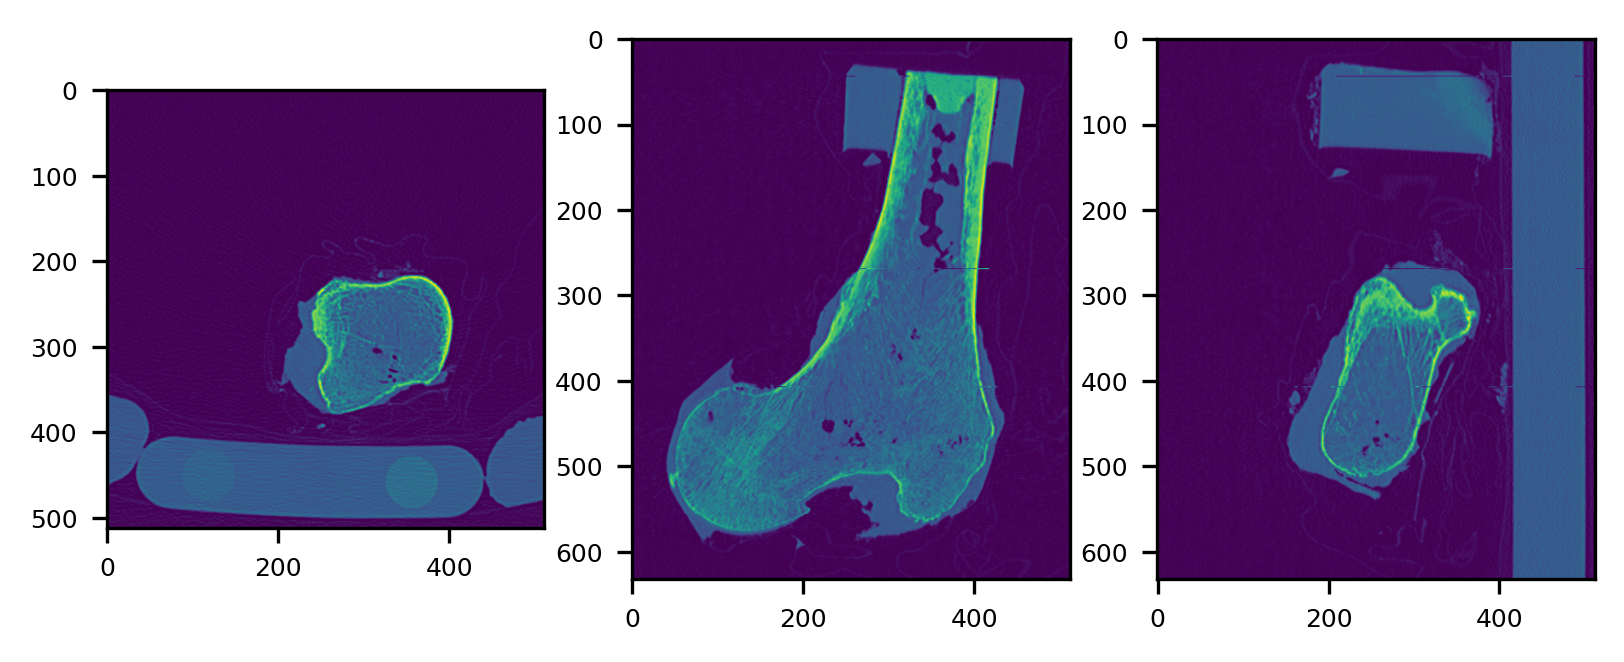

In [21]:
plot_midplanes_sitk(data_3D_QCT)

Write as single MHD file

In [56]:
# writer = sitk.ImageFileWriter()
# writer.SetFileName(output_QCT)
# writer.Execute(data_3D_QCT)

### Resample dataset
- resample image for faster test compartment masks calculation

In [235]:
# vs_QCT_new = np.array(vs_QCT)*2 # downsample with factor 2 (non isotropic!)
vs_QCT_new = np.min(vs_QCT) * np.ones([3]) # keep spacing close to the origingal one but isotropic
vs_QCT_res = 2 * vs_QCT_new
print(vs_QCT_res)
data_3D_QCT_res = resample_img(data_3D_QCT, out_spacing=vs_QCT_res)

[0.5859375 0.5859375 0.5859375]


- isotropic voxel size

In [236]:
print(vs_QCT_new)
data_3D_QCT = resample_img(data_3D_QCT, out_spacing=vs_QCT_new)

[0.29296875 0.29296875 0.29296875]


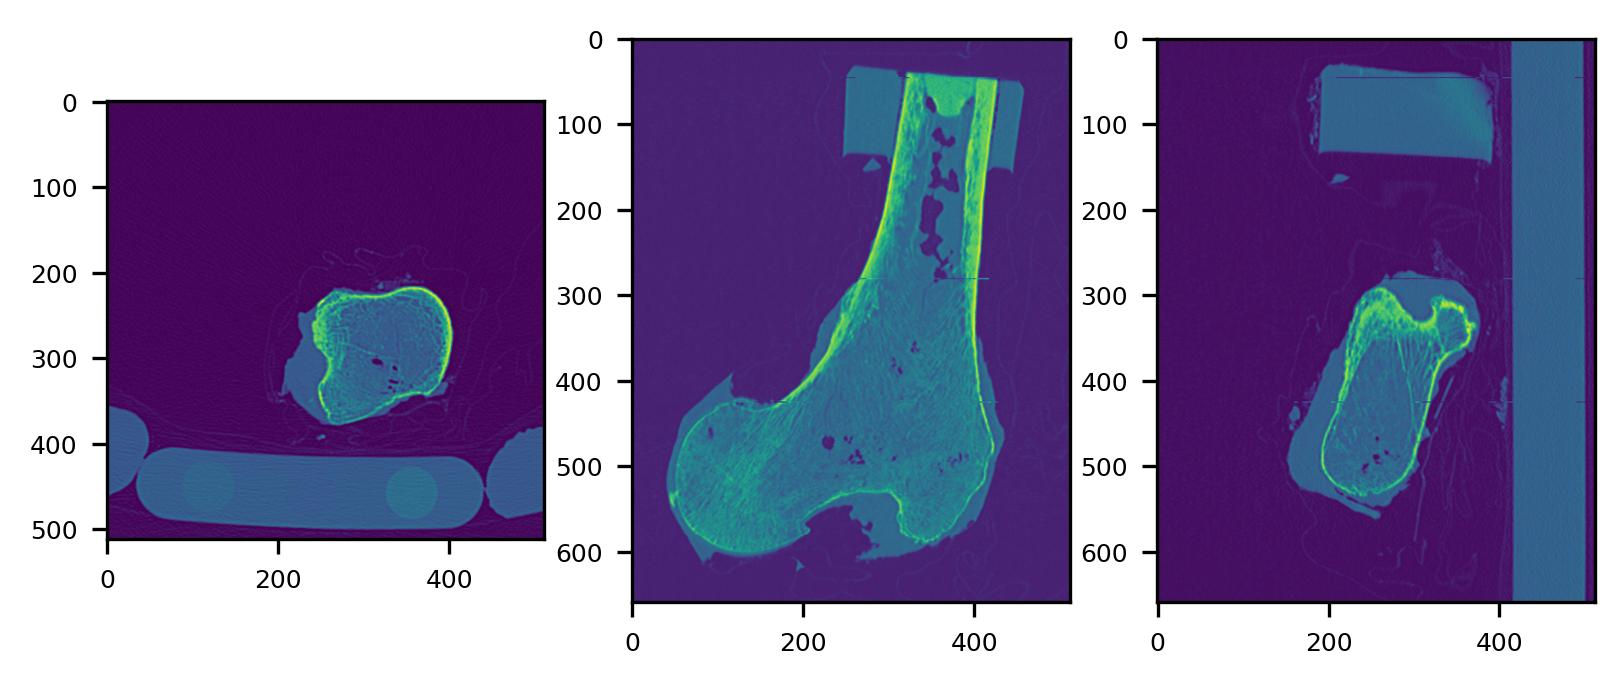

In [237]:
plot_midplanes_sitk(data_3D_QCT)

### Median filter
We create a filtered copy of the QCT dataset for segmentation of bone compartments

In [238]:
filter = sitk.MedianImageFilter()
filter.SetRadius(1)
data_3D_QCT_med = filter.Execute(data_3D_QCT_res)

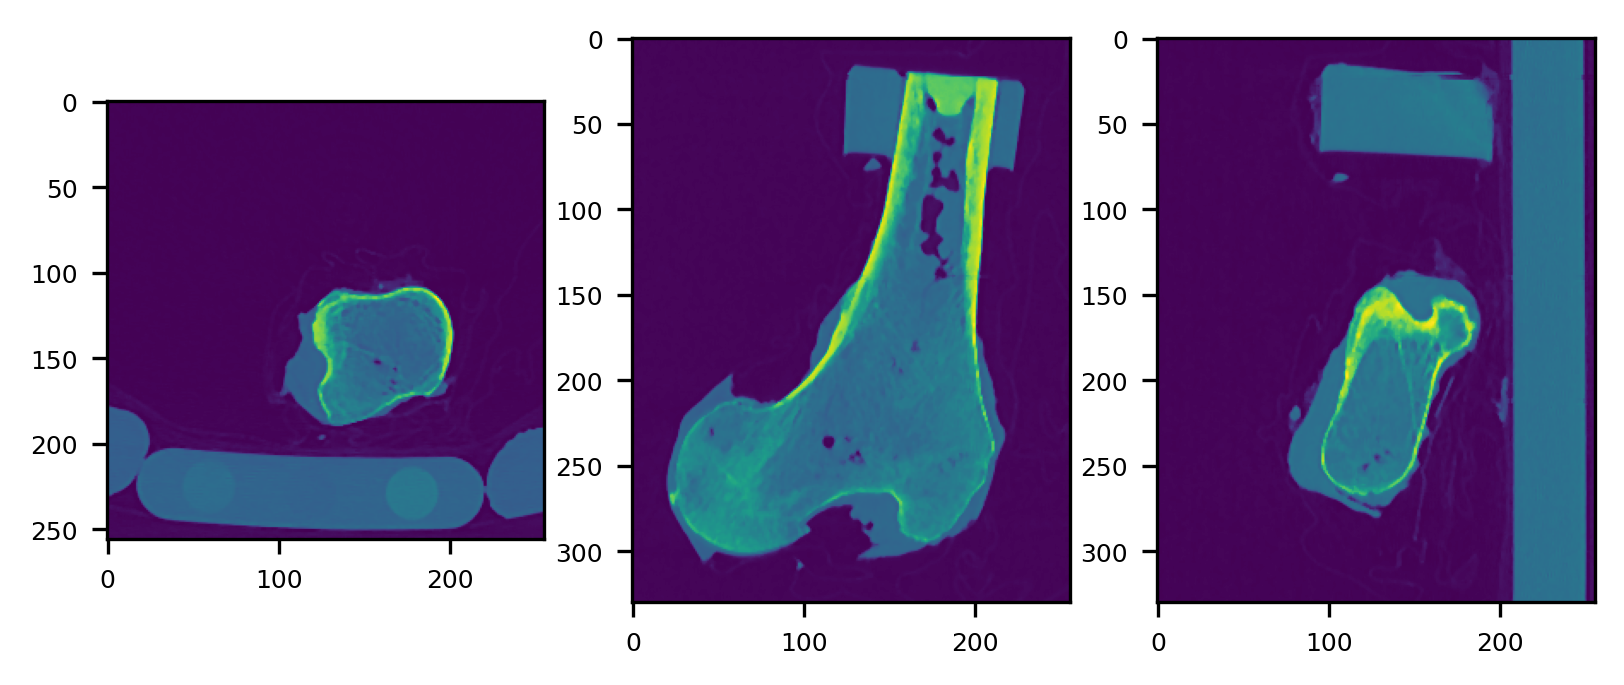

In [239]:
plot_midplanes_sitk(data_3D_QCT_med)

### Find cement markers
#### Segment markers and bone with multi otsu threshold
Multi-Otsu threshold of QCT dataset: 3 materials (backgroud, water, bone)

In [240]:
ts = threshold_multiotsu(sitk.GetArrayFromImage(data_3D_QCT_med))

Segment and perform image opening step to remove spurious voxels

In [241]:
data_3D_QCT_BW = morphology.binary_opening(sitk.GetArrayFromImage(data_3D_QCT_med) > ts[1])

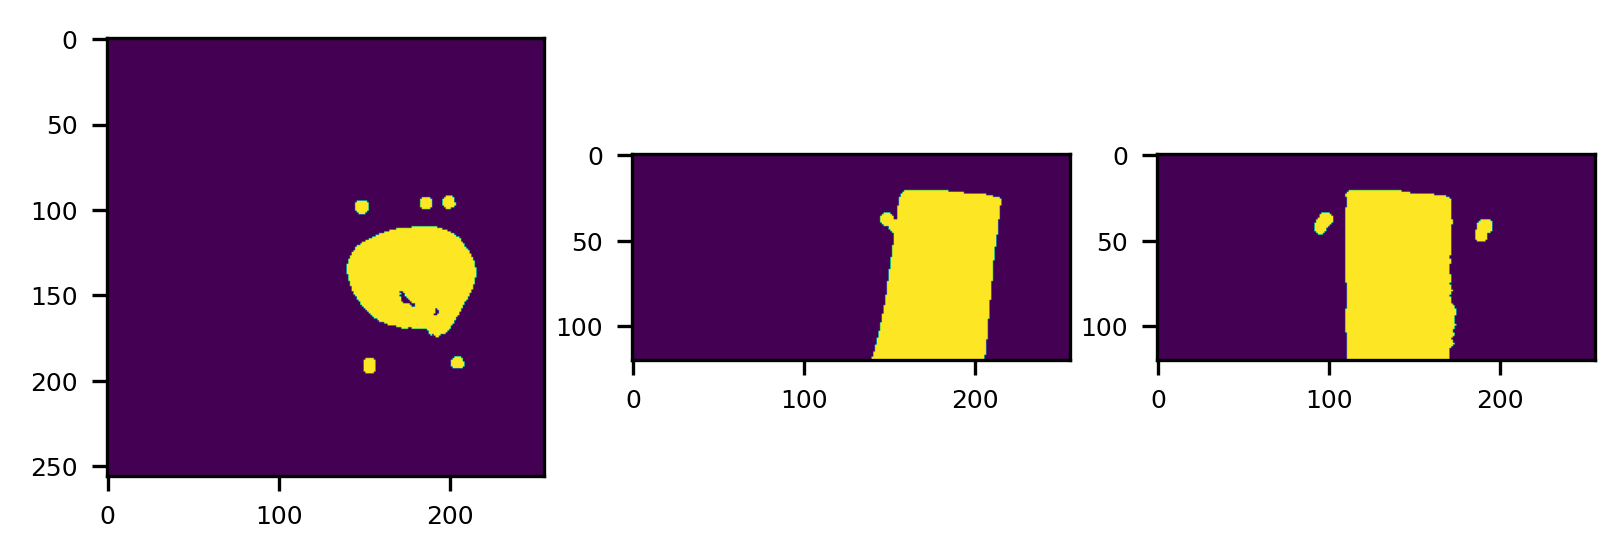

In [242]:
plot_projections(data_3D_QCT_BW[0:120,:,:])

#### Calculate markers coordinates
- QCT dataset:

In [243]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates = np.fliplr(markers_coordinates*data_3D_QCT_med.GetSpacing()) # [x, y, z]
print(markers_coordinates)

[[116.81161557  55.82326061  24.70224057]
 [ 87.00747283  57.54500679  21.85164742]
 [ 89.67242325 111.96374726  24.27357456]
 [119.75875687 110.88598901  27.18492445]
 [108.97180123  56.12174759  23.58335569]]


###  Alignment and registration rotation matrices
Get n12, n14, v12, and v14 vectors

In [250]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

v12 = markers_coordinates_HR[1,:] - markers_coordinates_HR[0,:]
v14 = markers_coordinates_HR[3,:] - markers_coordinates_HR[0,:]

#### Rotation matrix to allign QCT markers with X-Y plane

In [62]:
# R_xy = align_with_XYplane(n12, n14)
# print(R_xy)

#### Rotation matrix to allign QCT markers with HR-pQCT markers

In [251]:
R_HR = align_with_vectors(n12, n14, v12, v14)
print(R_HR)

Angle between n12 and n14: 90.00381081668291 deg
Angle between v12 and v14: 89.9231118453337 deg
[[ 0.15894486 -0.98726324  0.00691616]
 [ 0.97275108  0.15779846  0.16986754]
 [-0.16879534 -0.02027188  0.98544263]]


Store transformation matrix

In [35]:
output_R_HR = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/QCTFEMUR_1955L_R_HR.npy')
np.save(output_R_HR, R_HR)

### Apply affine transformation to QCT stack

Apply the transformation matrix to the markers coordinates

In [266]:
print(markers_coordinates)

[[116.81161557  55.82326061  24.70224057]
 [ 87.00747283  57.54500679  21.85164742]
 [ 89.67242325 111.96374726  24.27357456]
 [119.75875687 110.88598901  27.18492445]
 [108.97180123  56.12174759  23.58335569]]


In [265]:
markers_coordinates_trans = np.matmul(markers_coordinates, R_HR)
print(markers_coordinates_trans)

[[  68.69912042 -107.01574973   34.63308835]
 [  66.11790228  -77.26173956   31.91033105]
 [ 119.06856101  -71.35465066   43.55941024]
 [ 122.31081644 -101.28686887   46.45338414]
 [  67.93223827  -99.20600659   33.52697336]]


In [267]:
print(markers_coordinates_HR)

[[101.714  92.103  14.022]
 [ 95.215  62.903  16.21 ]
 [ 41.419  74.894  16.994]
 [ 47.57  104.14   14.859]
 [100.051  84.267  14.167]]


#### Transform dataset - align with HR-pQCT dataset
Apply the same transformation to:
1. data_3D_QCT     - QCT dataset
2. data_3D_QCT_med - median resampled version of QCT (for binary compartment masks calculation)

In [262]:
data_3D_QCT_trans = affine_trans(data_3D_QCT, tmatrix=R_HR) # R_1rot

In [263]:
data_3D_QCT_med = affine_trans(data_3D_QCT_med, tmatrix=R_HR) # R_1rot

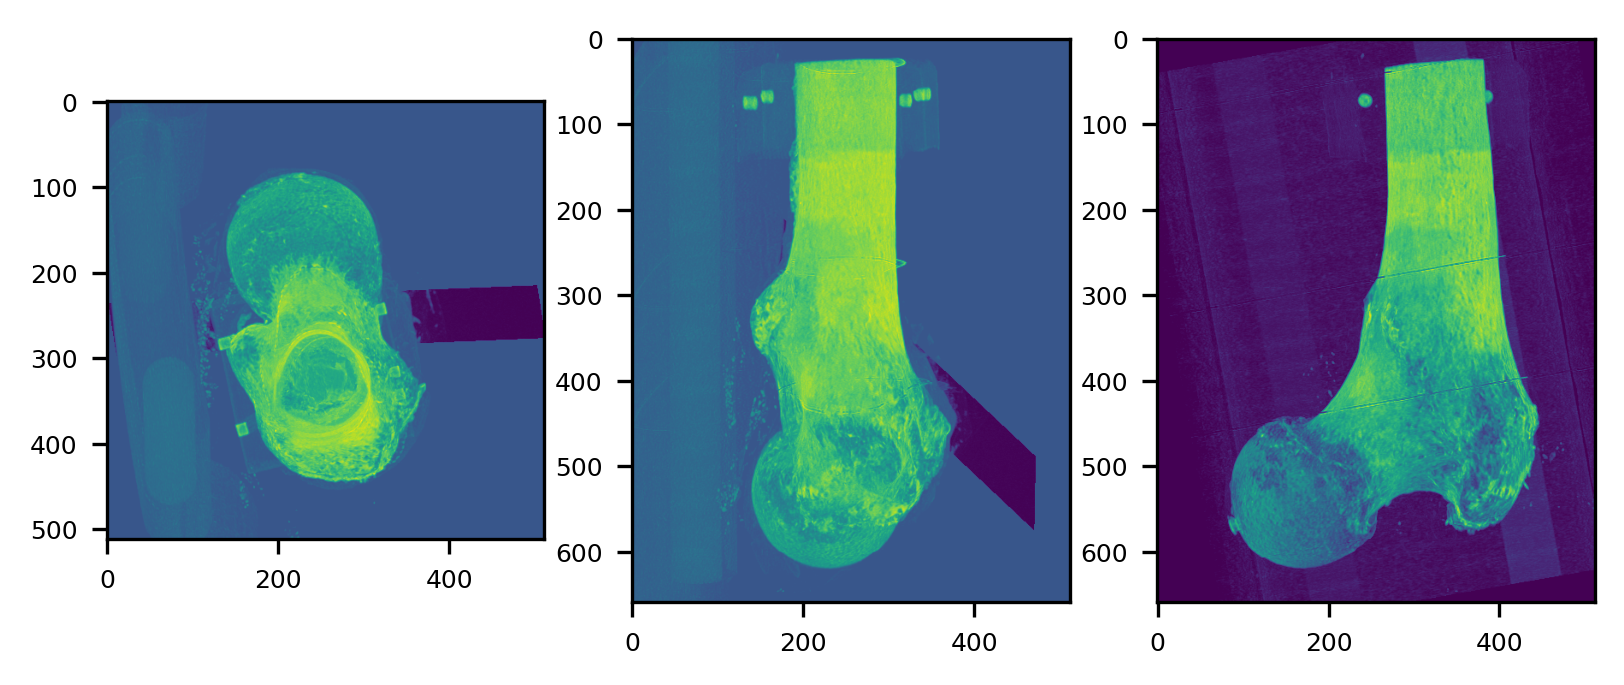

In [277]:
plot_projections_sitk(data_3D_QCT_trans)

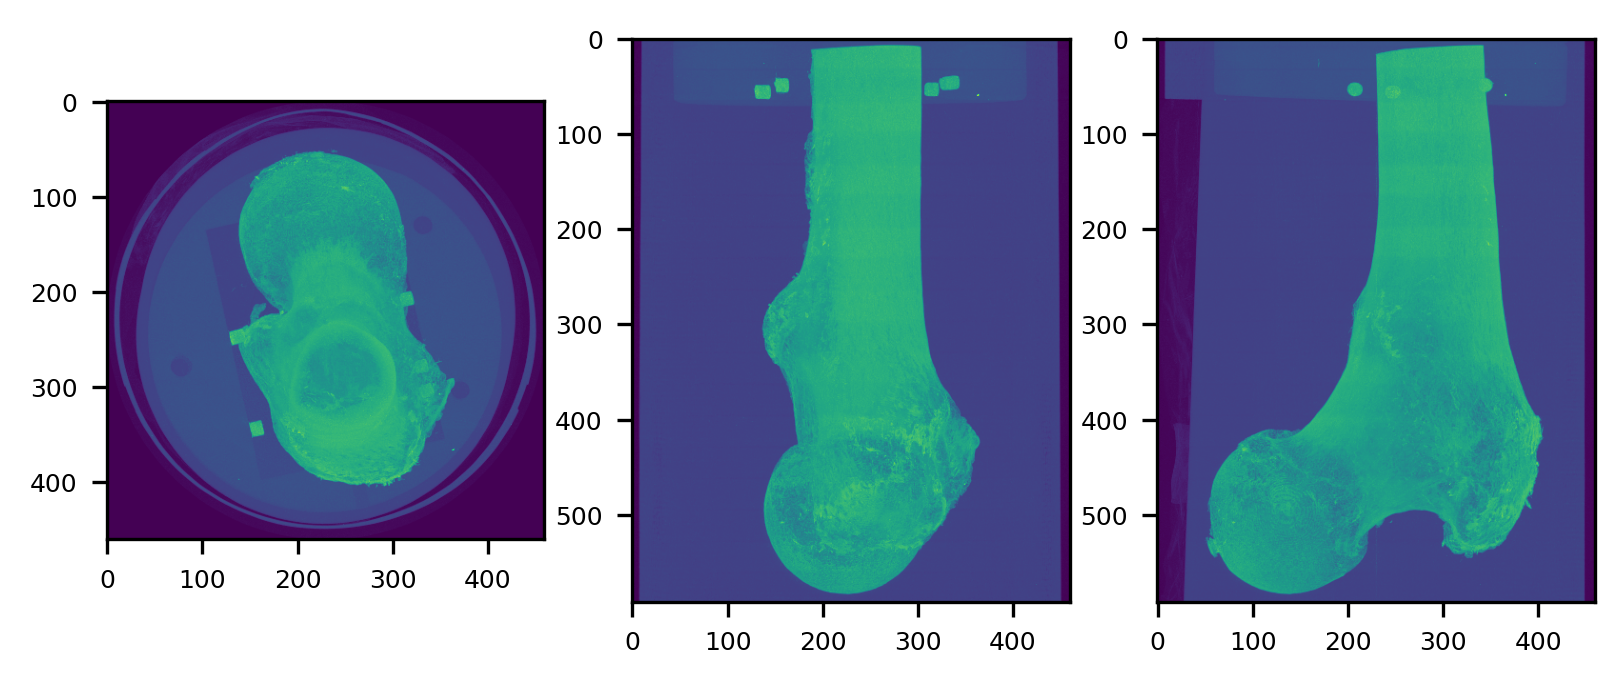

In [38]:
# plot_projections_sitk(data_3D)

#### Recalculate markers coordinates on transformed QCT image

In [285]:
data_3D_QCT_BW_trans = morphology.binary_opening(sitk.GetArrayFromImage(data_3D_QCT_med) > ts[1])

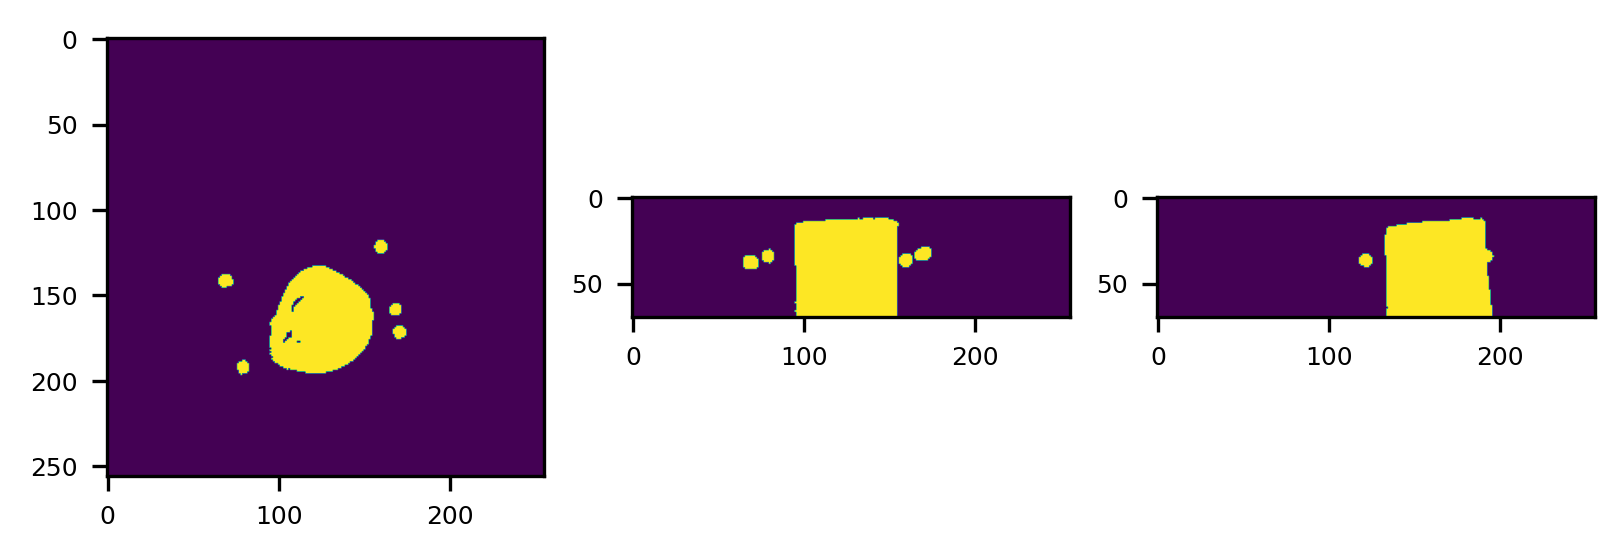

In [287]:
plot_projections(data_3D_QCT_BW_trans[0:70,:,:])

In [288]:
markers_coordinates_trans = markers_coors(data_3D_QCT_BW_trans[0:70,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates_trans = np.fliplr(markers_coordinates_trans*data_3D_QCT_med.GetSpacing()) # [x, y, z]
print(markers_coordinates_trans)

[[100.03169222 100.47169811  19.08387382]
 [ 93.60463383  71.2316615   21.26595301]
 [ 40.34623053  82.79453357  22.05698257]
 [ 46.25883557 112.37676711  19.9265253 ]
 [ 98.61091648  92.64118554  19.23871917]]


Check correct position of markers coordinates on transformed image

In [289]:
markers_slice_trans = int(np.mean(markers_coordinates_trans[:,2])/data_3D_QCT_trans.GetSpacing()[2])
markers_pixel_trans = (markers_coordinates_trans / data_3D_QCT_trans.GetSpacing()).astype('uint')

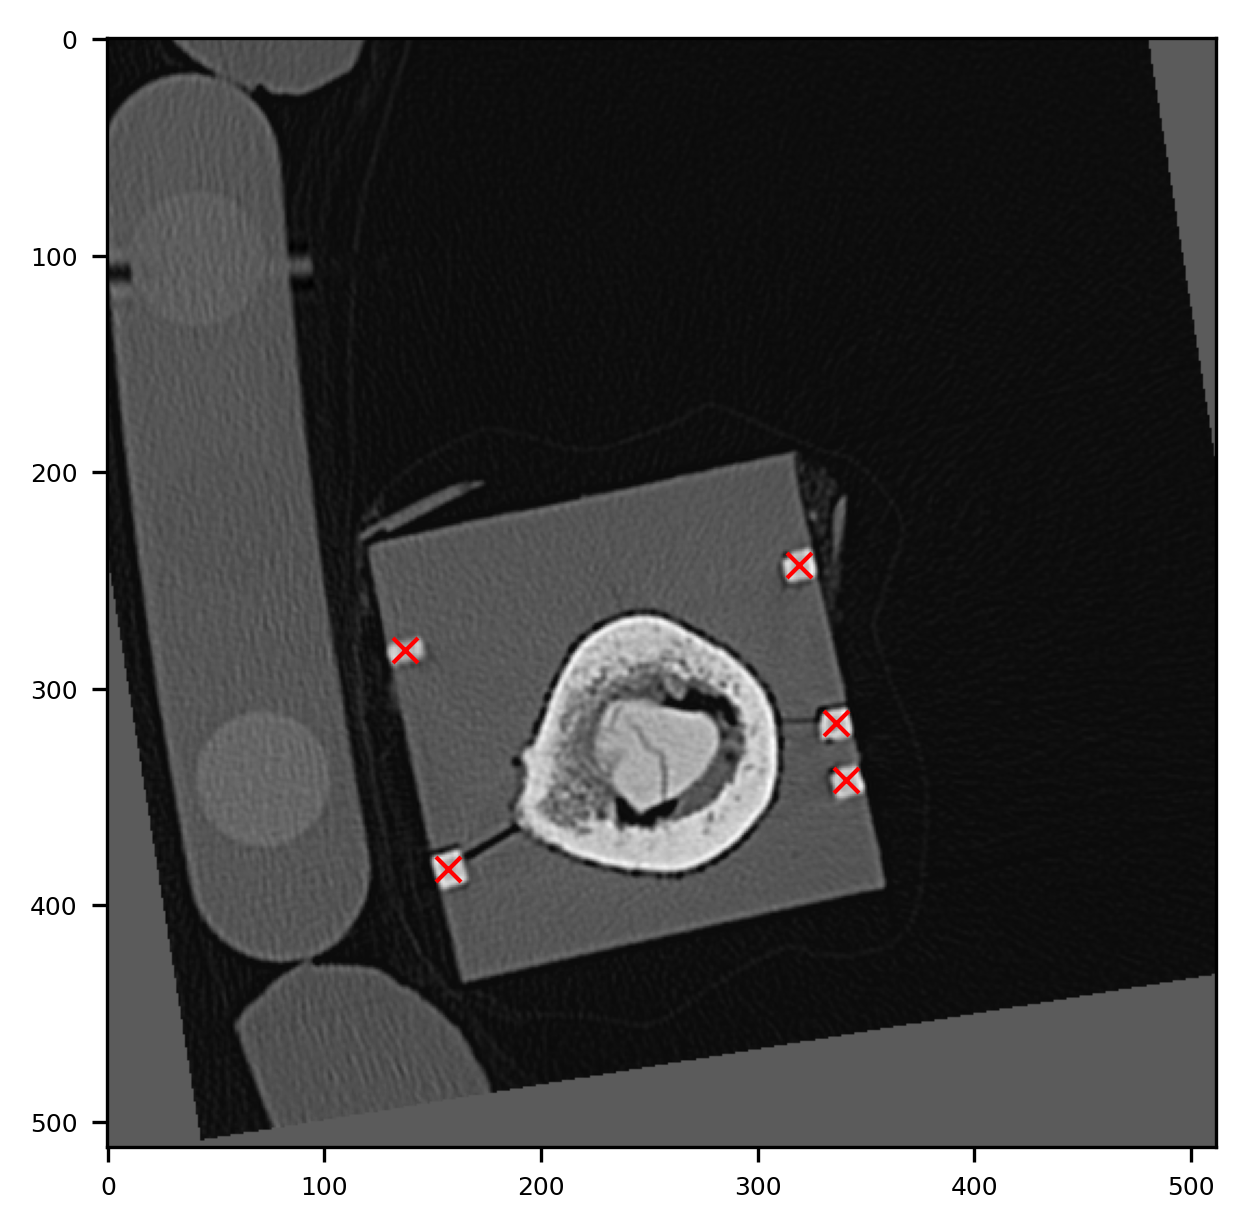

In [291]:
plt.imshow(sitk.GetArrayFromImage(data_3D_QCT_trans)[markers_slice_trans,:,:], cmap='grey')
plt.plot(markers_pixel_trans[:,0], markers_pixel_trans[:,1], 'xr')

#### Get offset between HR-pQCT and transformed QCT images

In [298]:
Offset_HR_QCTtrans = np.mean(markers_coordinates_HR - markers_coordinates_trans, axis=0)
print(Offset_HR_QCTtrans)

[ 1.42333828 -8.24176917 -5.06401077]


#### Fix QCT transformed image origin to include the offset

In [301]:
data_3D_QCT_trans.SetOrigin(data_3D_QCT_trans.GetOrigin()+Offset_HR_QCTtrans)

In [303]:
data_3D_QCT_med.SetOrigin(data_3D_QCT_med.GetOrigin()+Offset_HR_QCTtrans)

#### Write transformed dataset as single MHD file

In [31]:
output_QCT_R_HR = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/QCTFEMUR_1955L_R_HR.mhd')

In [39]:
writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR)
writer.Execute(data_3D_QCT_trans)

Read again the transformed QCT dataset

In [32]:
data_3D_QCT_trans = sitk.ReadImage(output_QCT_R_HR, imageIO="MetaImageIO")

## Bone compartments masks
### Whole bone mask (periosteum mask)

In [305]:
# data_3D_BW_peri = periosteummask(data_3D>(ts_HR[1]-1000), closepixels=10, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)
data_3D_QCT_BW_peri = periosteummask(sitk.GetArrayFromImage(data_3D_QCT_med)>(ts[1]-400), closepixels=5, closevoxels=5, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

INFO:root:Preliminary removal of objects smaller than 1 pixels.
INFO:root:2D slice-wise image closing and filling.
 Structuring element DISK of radius: 5
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:01<00:00, 177.53it/s]
INFO:root:Removing isolated clusters of voxels.
INFO:root:Final 3D image closing.
 Structuring element CUBE of radius: 5


Assign to a new itk image

In [306]:
data_3D_QCT_BW_peri = sitk.GetImageFromArray(data_3D_QCT_BW_peri.astype('uint8'))
data_3D_QCT_BW_peri.CopyInformation(data_3D_QCT_med)

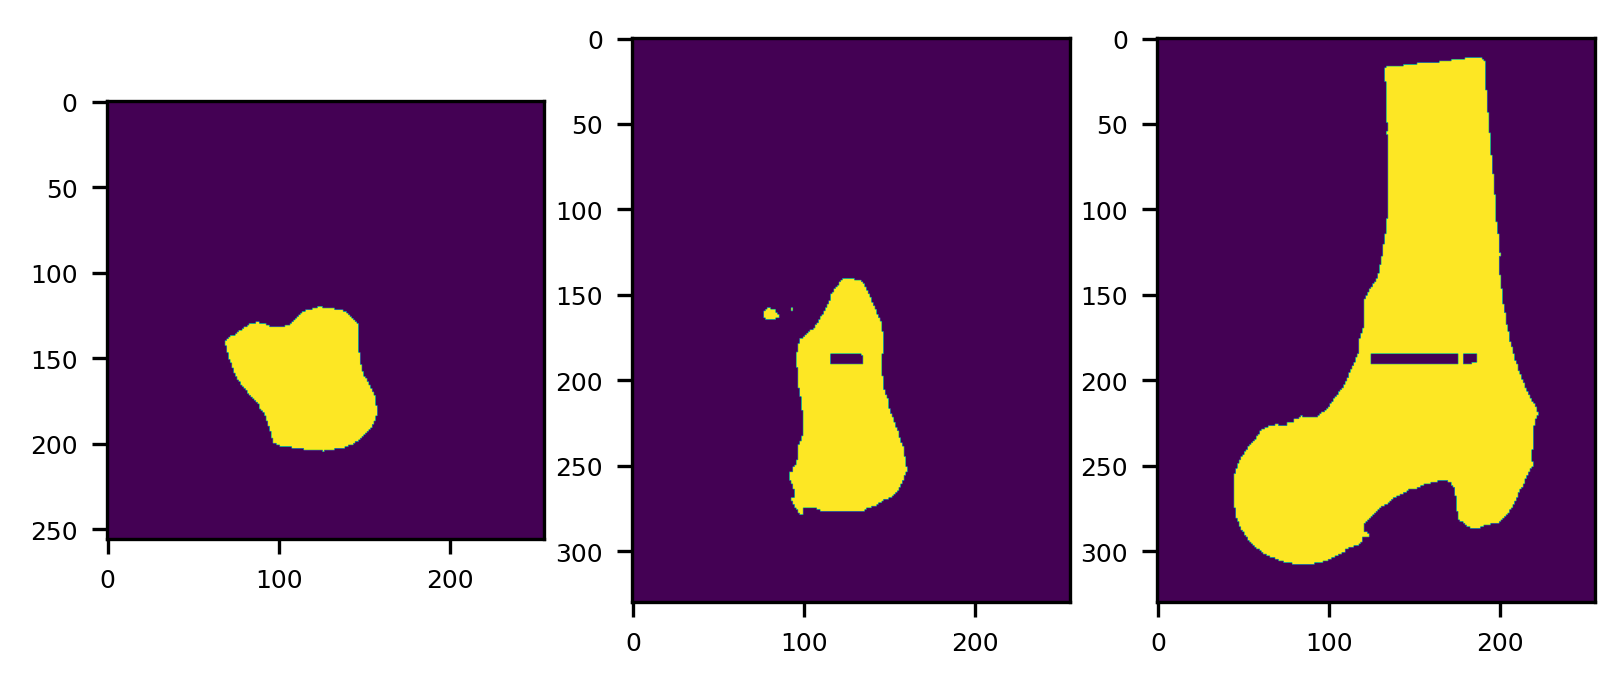

In [307]:
# plot_midplanes_sitk(data_3D_QCT_med>(ts[1])-500)
plot_midplanes_sitk(data_3D_QCT_BW_peri)

### Iterative Voting Hole Filling Filter
Performs the filling operation multiple times until no pixels change, or maximum number of iterations is reached.

In [308]:
hole_filling_filter = sitk.VotingBinaryIterativeHoleFillingImageFilter()
hole_filling_filter.SetRadius(3)
hole_filling_filter.SetMajorityThreshold(1)
hole_filling_filter.SetBackgroundValue(0)
hole_filling_filter.SetForegroundValue(1)
hole_filled_image = hole_filling_filter.Execute(data_3D_QCT_BW_peri)

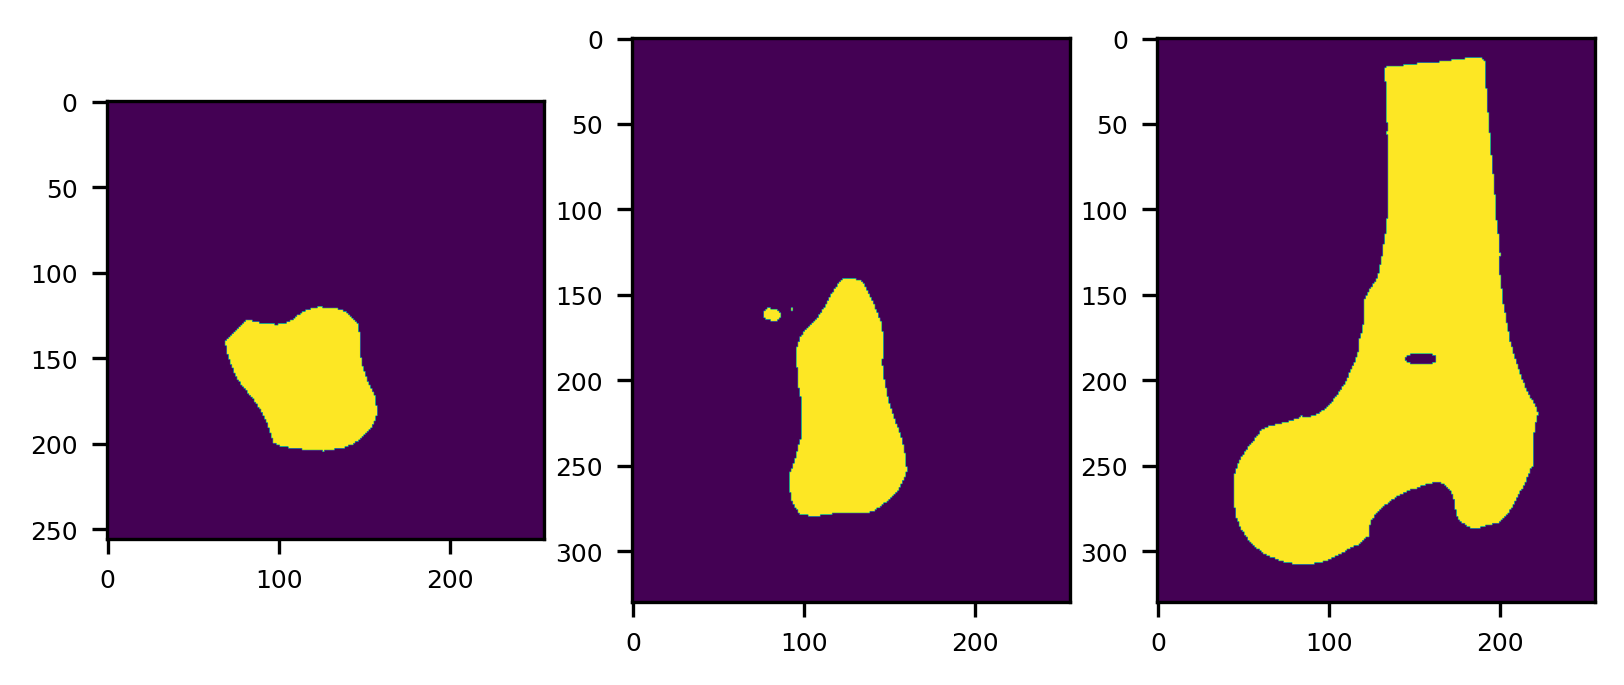

In [309]:
plot_midplanes_sitk(hole_filled_image)

### Image close

In [310]:
closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelRadius(8)
data_3D_QCT_BW_peri = closing_filter.Execute(hole_filled_image)

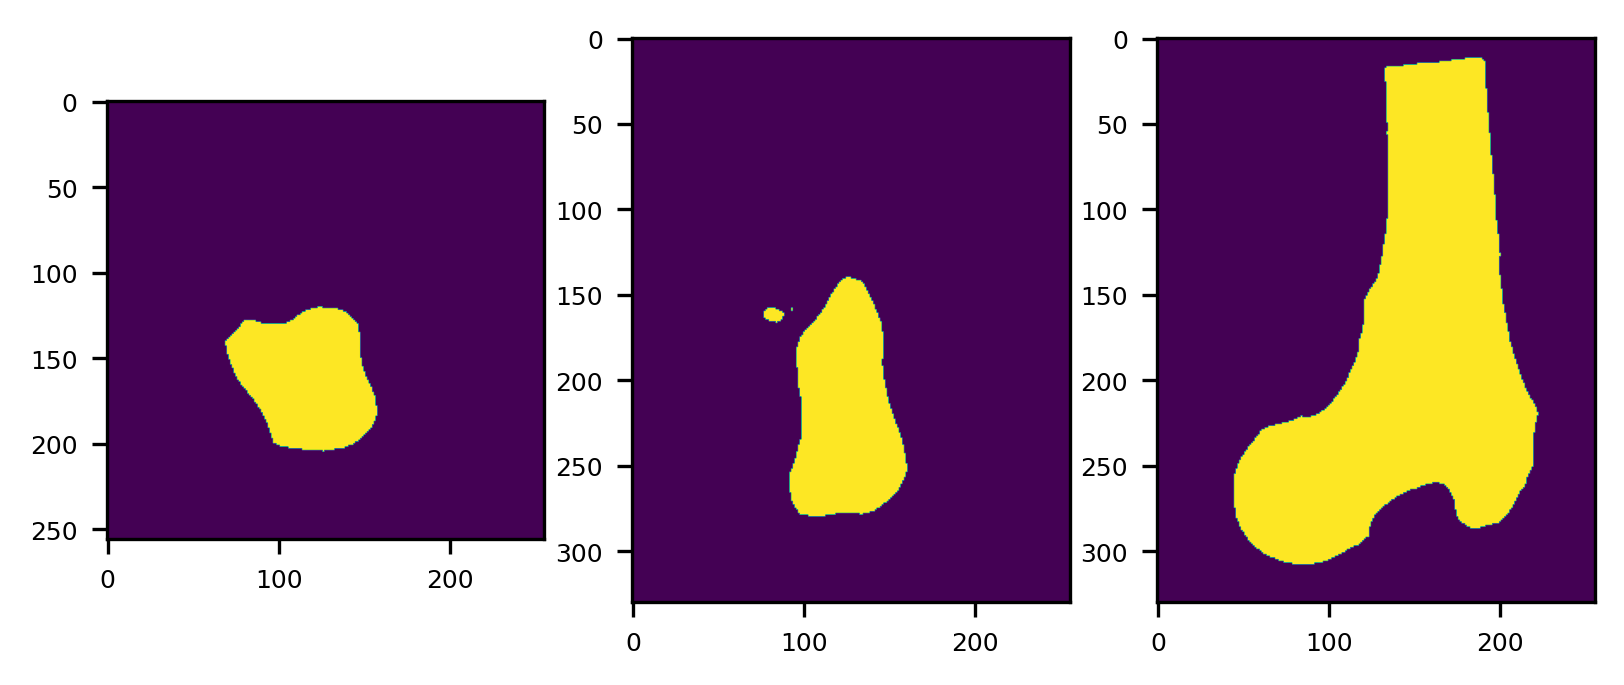

In [311]:
plot_midplanes_sitk(data_3D_QCT_BW_peri)

#### Write whole bone mask

In [312]:
output_QCT_R_HR_whole_bone = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_whole_bone.mhd')

writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR_whole_bone)
writer.Execute(data_3D_QCT_BW_peri)

### Trabecular bone mask
We erode 5 mm from the surface of the whole bone mask to obtain a tentative mesh of the trabecular core

In [319]:
offset_from_cortex = 5 # mm
kernel_radius = int(offset_from_cortex / data_3D_QCT_BW_peri.GetSpacing()[0])

In [320]:
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius(kernel_radius)
data_3D_BW_trab = erode_filter.Execute(data_3D_QCT_BW_peri)

Delete shaft portion from mask: this is done to remove thin struts and facilitate meshing

In [321]:
tmp = sitk.GetArrayFromImage(data_3D_BW_trab).astype('uint8')
tmp[0:100, :, :] = 0
data_3D_BW_trab = sitk.GetImageFromArray(tmp)
data_3D_BW_trab.CopyInformation(data_3D_QCT_BW_peri)

In [1]:
# myshow(sitk.LabelOverlay(data_3D_QCT, data_3D_BW_trab))

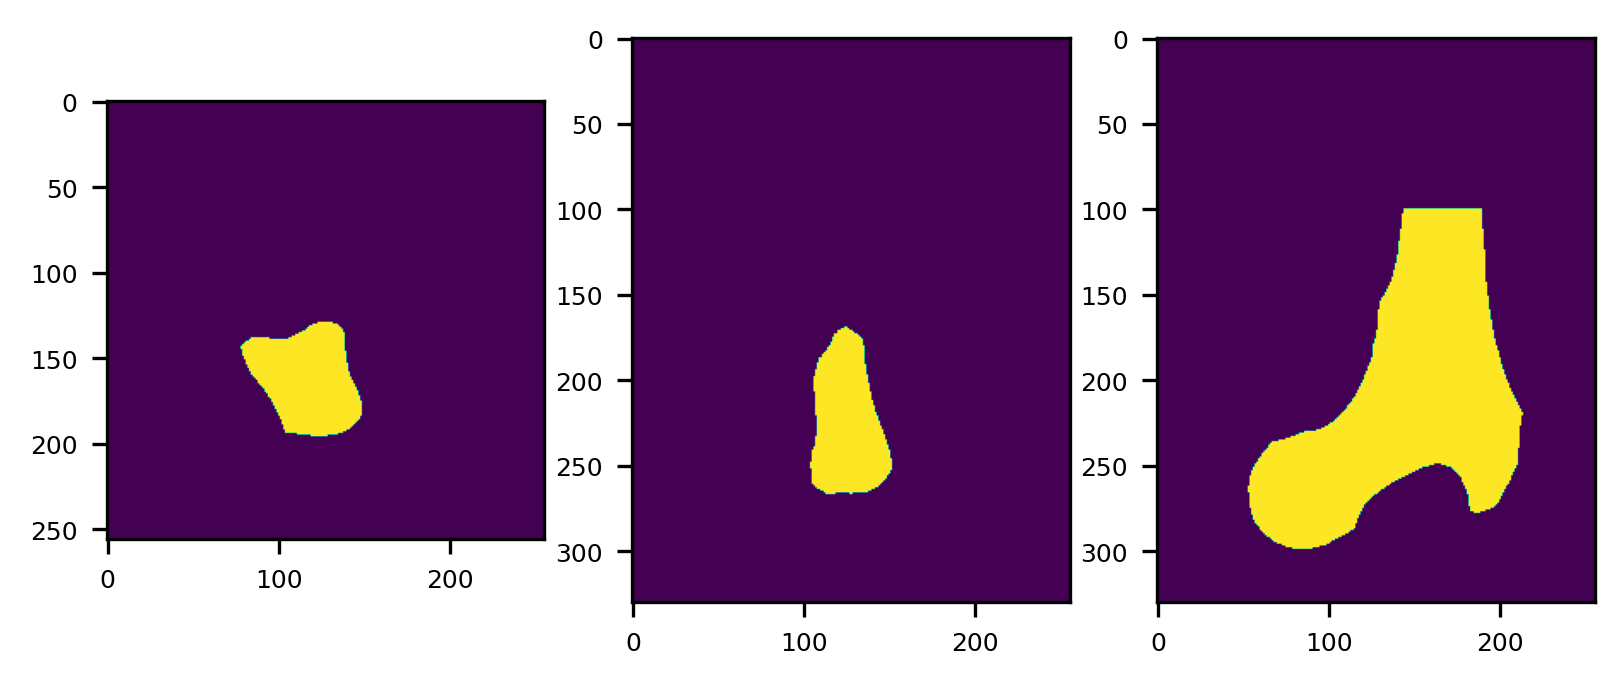

In [322]:
plot_midplanes_sitk(data_3D_BW_trab)

#### Write trabecular core mask

In [324]:
output_QCT_R_HR_trab = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab.mhd')

writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR_trab)
writer.Execute(data_3D_BW_trab)

## Mesh of trabecular core
Create tetrahedra mesh of trabecular core: volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [ ]:
import pygalmesh

In [35]:
# mesh_trab = pygalmesh.generate_from_array(np.transpose(data_3D_BW_trab, [2, 1, 0]).astype('uint8'),
#                                           tuple(vs),
#                                           max_facet_distance=size_f*min(vs),
#                                           max_cell_circumradius=3*size_f*min(vs)
#                                          )

In [208]:
# min_facet_angle=20,  lloyd=True,
size_f = 4 # size factor
mesh_trab = pygalmesh.generate_from_array(np.transpose(sitk.GetArrayFromImage(data_3D_BW_trab), [2, 1, 0]),
                                          data_3D_BW_trab.GetSpacing(),
                                          max_facet_distance=size_f*min(data_3D_BW_trab.GetSpacing()),
                                          max_cell_circumradius=3*size_f*min(data_3D_BW_trab.GetSpacing())
                                         )

construct initial points (nb_points: 12)
12/12 initial point(s) found...
Start surface scan...Scanning triangulation for bad facets (sequential) - number of finite facets = 52...
Number of bad facets: 12
scanning edges (lazy)
scanning vertices (lazy)
end scan. [Bad facets:12]

Refining Surface...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(60,47,0,0) (9627.5 vertices/s))
Total refining surface time: 0.00490308s

Start volume scan...Scanning triangulation for bad cells (sequential)... 255 cells scanned, done.
Number of bad cells: 100
end scan. [Bad tets:100]

Refining...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(87,38,0,0) (13649.4 vertices/s))
Total refining volume time: 0.00280404s
Total refining time: 0.00829411s

Running sliver perturbation...
Legend of the following line: (#vertices in pqueue, #iterations, #fails)
bound 12: (8,5,0) (599.6 iteration/s))
Total perturbation time: 0.00835514s
Perturbation

Remove triangles

In [210]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [16]:
output_QCT_R_HR_mesh_trab = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm_noOrigin.vtk')
print(output_QCT_R_HR_mesh_trab)

/run/media/beatsbs/My Passport/Data/TacoSound/QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm.vtk


In [212]:
mesh_trab.write(output_QCT_R_HR_mesh_trab)

Reload the mesh (if you have already generated it and want to start the notebook from this point)

In [9]:
import meshio
mesh_trab = meshio.read(output_QCT_R_HR_mesh_trab)

### Get Barycenter of each cell of the trabecular core (QCT data)

In [217]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1] # x, y, z

Save array of cells barycenters coordinates

In [181]:
output_trab_cells_bary = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm_barycenters_noOrigin.npy')
print(output_trab_cells_bary)

/run/media/beatsbs/My Passport/Data/TacoSound/QCT/QCTFEMUR_1955L/masks/QCTFEMUR_1955L_R_HR_trab_mesh_max_facet3mm_max_cell_circ9mm_barycenters_noOrigin.npy


In [219]:
np.save(output_trab_cells_bary, cells_bary)

Reload it

In [182]:
cells_bary = np.load(output_trab_cells_bary)
print(cells_bary.shape)

(885, 3)


## Crop trabecular bone portions
--- testing ---

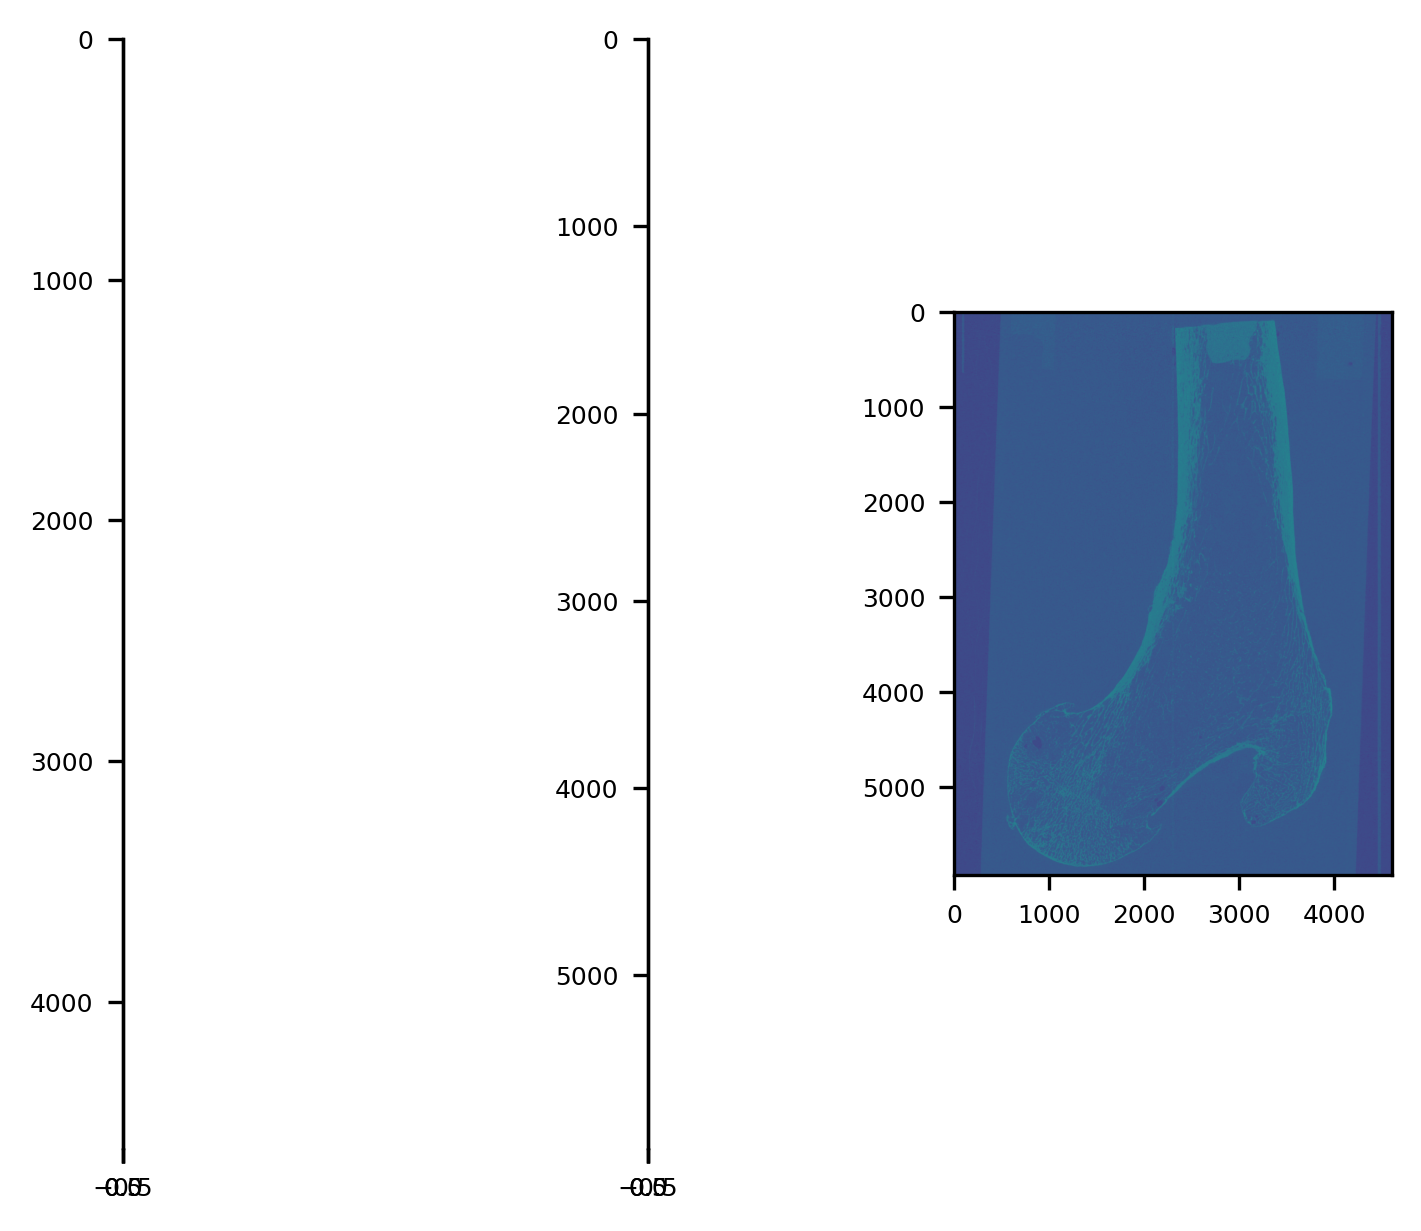

In [196]:
extract = sitk.ExtractImageFilter()
extract.SetSize([1, 4608, 5921])
extract.SetIndex([2304, 0, 0])
extracted_image = extract.Execute(data_3D)

plot_midplanes_sitk(extracted_image)

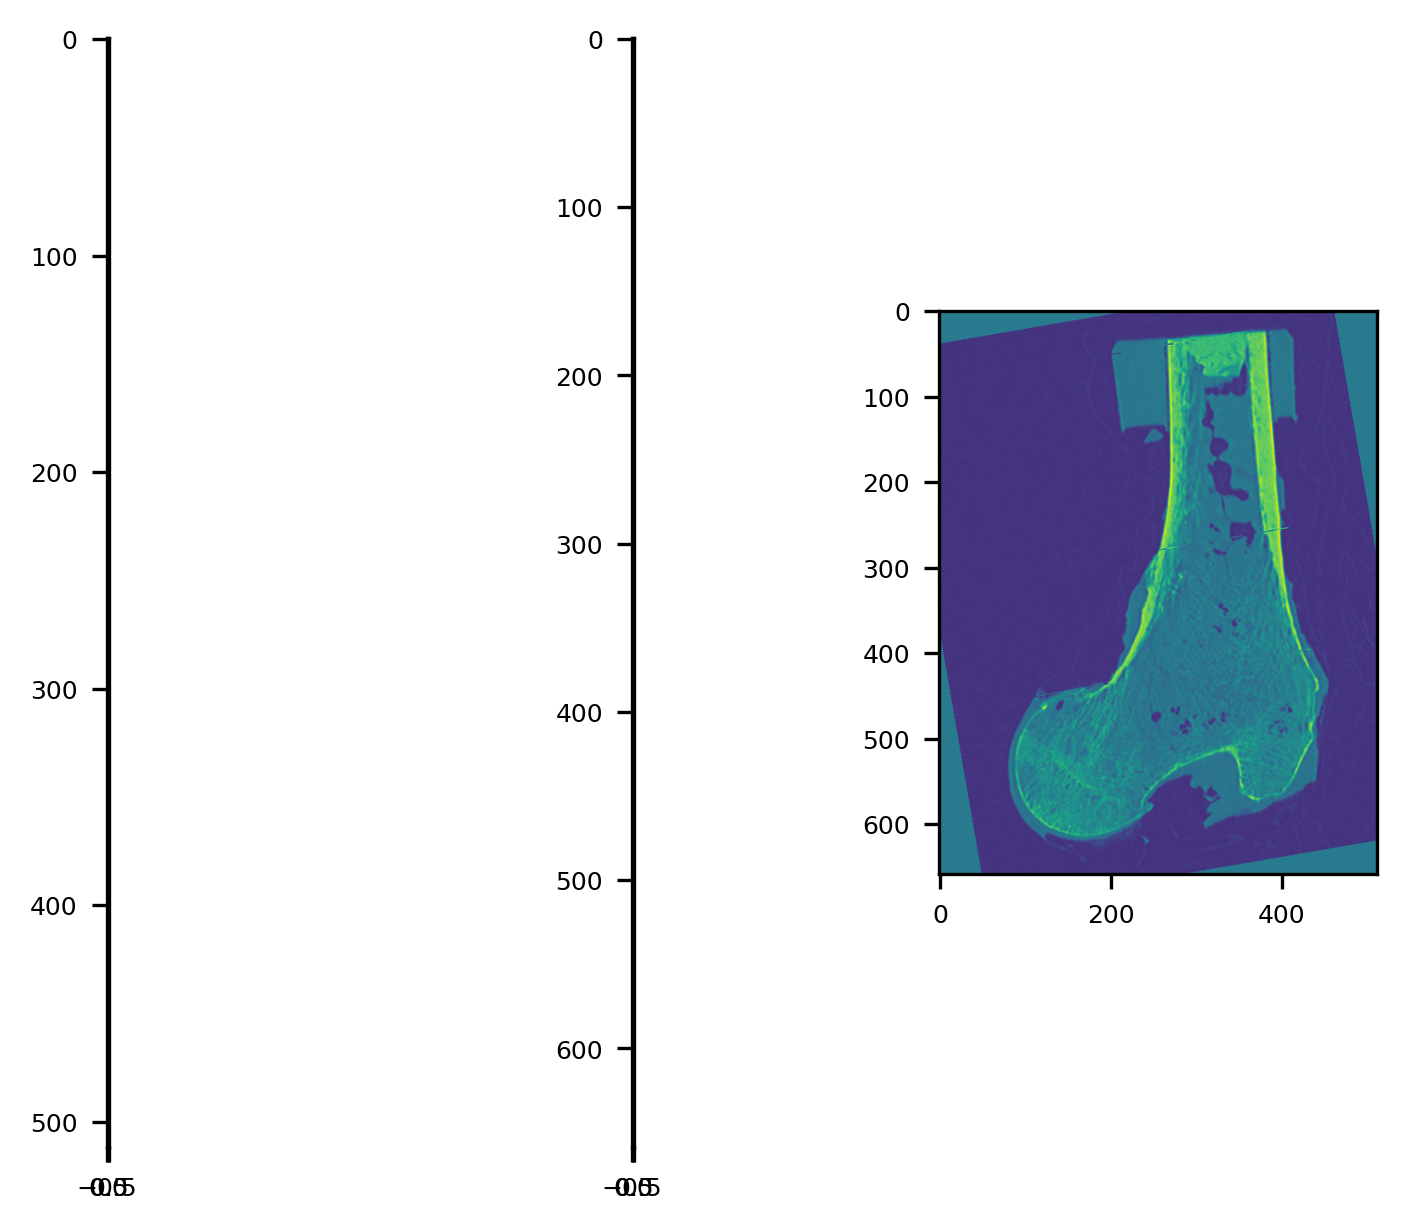

In [232]:
extract = sitk.ExtractImageFilter()
extract.SetSize([1, 512, 659])
extract.SetIndex([256, 0, 0])
extracted_image = extract.Execute(data_3D_QCT_trans)

plot_midplanes_sitk(extracted_image)

In [204]:
(cells_bary[id] - size/2)/data_3D.GetSpacing()

array([2139.95208939, 3401.69011577, 1948.45594646])

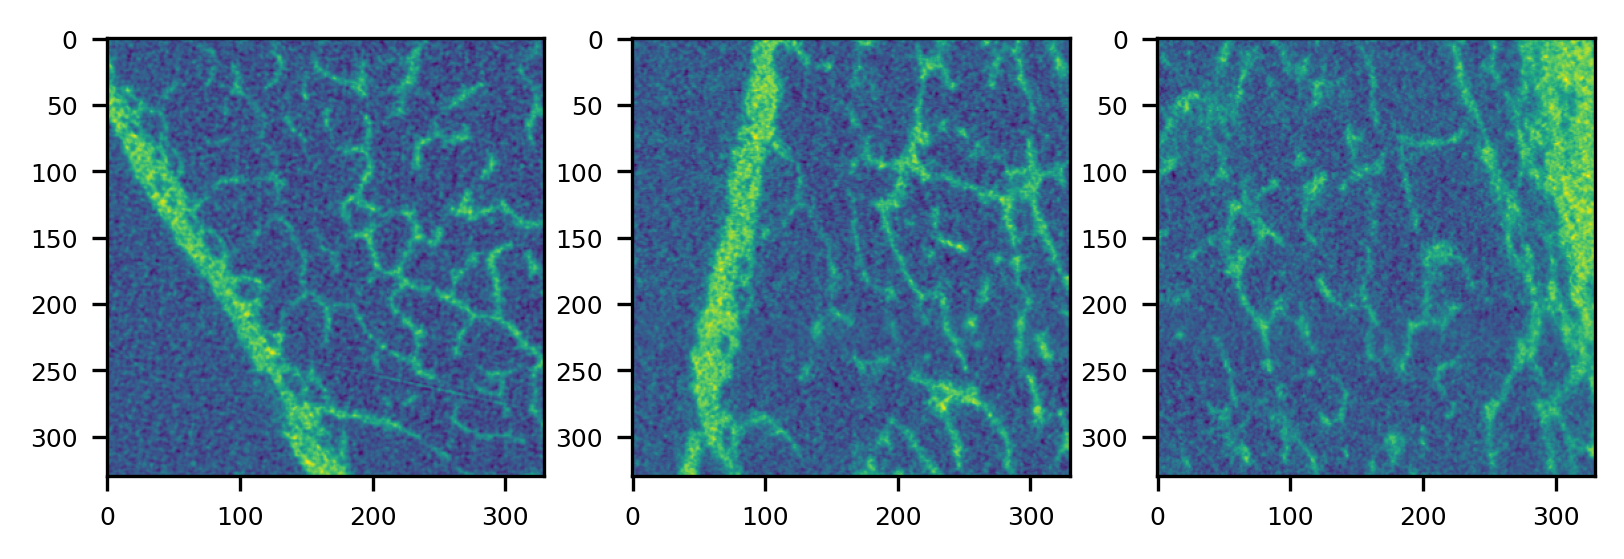

In [229]:
id = 376
size = np.array([5., 5., 5.]) # mm
size = np.array([10., 10., 10.]) # mm
# print(cells_bary[id])
# print(np.round((cells_bary[id] - size/2)/data_3D_BW_trab.GetSpacing()).astype('int'))
# print(np.round((cells_bary[id] + size/2)/data_3D_BW_trab.GetSpacing()).astype('int'))

# crop HR-pQCT data
# crop_start = np.round(((cells_bary[id] - data_3D_QCT_trans.GetOrigin()) - size/2)/data_3D.GetSpacing()).astype('int')
# crop_end = np.round(((cells_bary[id] - data_3D_QCT_trans.GetOrigin()) + size/2)/data_3D.GetSpacing()).astype('int')
crop_start = np.round((cells_bary[id] - size/2)/data_3D.GetSpacing()).astype('int')
crop_end = np.round((cells_bary[id] + size/2)/data_3D.GetSpacing()).astype('int')
crop_size = crop_end - crop_start

# Select same subregion using ExtractImageFilter
extract = sitk.ExtractImageFilter()
extract.SetSize(crop_size.tolist())
extract.SetIndex(crop_start.tolist())
extracted_image = extract.Execute(data_3D)

plot_midplanes_sitk(extracted_image)

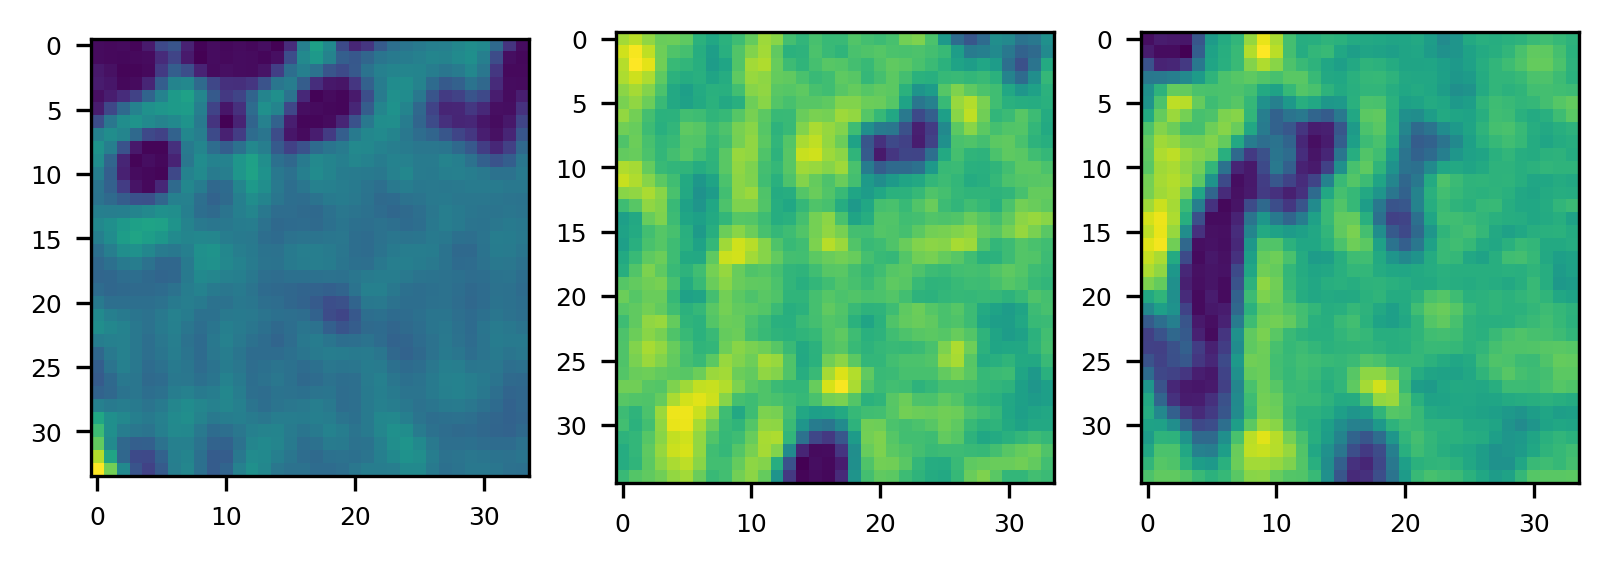

In [230]:
# crop QCT data
crop_start = np.round((cells_bary[id] - size/2)/data_3D_QCT_trans.GetSpacing()).astype('int')
crop_end = np.round((cells_bary[id] + size/2)/data_3D_QCT_trans.GetSpacing()).astype('int')
crop_size = crop_end - crop_start

# Select same subregion using ExtractImageFilter
extract = sitk.ExtractImageFilter()
extract.SetSize(crop_size.tolist())
extract.SetIndex(crop_start.tolist())
extracted_image_QCT = extract.Execute(data_3D_QCT_trans)

plot_midplanes_sitk(extracted_image_QCT)

In [ ]:
# crop QCT data
crop_start = np.round((cells_bary[id] - size/2)/data_3D_QCT.GetSpacing()).astype('int')
crop_end = np.round((cells_bary[id] + size/2)/data_3D_QCT.GetSpacing()).astype('int')
# crop_size = crop_end - crop_start

test_crop_QCT = sitk.GetArrayFromImage(data_3D_QCT)[crop_start[2]:crop_end[2],crop_start[1]:crop_end[1],crop_start[0]:crop_end[0]]
# print(test_crop_QCT.shape)

plot_midplanes(test_crop_QCT)

In [207]:
cells_bary[42]/data_3D_QCT.GetSpacing()

array([398.67054688, 249.76      , 393.87334532])

---
# scratch: